# GNNExplainer

In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
from torch_geometric.loader import DataLoader
from torch.optim import AdamW
from utils.data import (
    load_dataframes,
    summary_statistics,
)
from exploration.graph_creation import *
from models.graphensemble.multigraph import *
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig
from torch_geometric.utils import to_networkx
from exploration.get_graphs_and_data import *

/home/ltchen/gnnpp


In [2]:
leadtime = "24h"
graph_name = "g1"
# data_type = "f"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

SAVEPATH, JSONPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name)

In [3]:
# dataframes = load_dataframes(leadtime=leadtime)
# dataframes = summary_statistics(dataframes)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [4]:
graph_name = "g1"
drn = False
if drn == True:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/drn_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"trained_models/drn_{leadtime}/params.json")
else:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/params.json")


with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/params.json


In [5]:
graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo"], edges=[("geo", 50)], sum_stats = True)
graphs1_valid_rf, graphs1_test_rf, graphs1_test_f = tests1

g1_train_loader = DataLoader(graphs1_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(graphs1_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(graphs1_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(graphs1_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs1_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs1_train_rf[0].num_edge_features
# max_epochs = max_epoch_list[graph_name]
num_nodes = graphs1_train_rf[0].num_nodes

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3


100%|██████████| 730/730 [00:02<00:00, 254.51it/s]


In [6]:
TRAINNAME = f"{graph_name}_{leadtime}_train_run7"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
# RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")
RESULTPATH = JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}")
print(RESULTPATH)

multigraph = Multigraph.load_from_checkpoint(
    CKPT_PATH,
    num_nodes=num_nodes,
    embedding_dim=emb_dim,
    edge_dim=edge_dim,
    in_channels=in_channels,
    hidden_channels_gnn=config['gnn_hidden'],
    out_channels_gnn=config['gnn_hidden'],
    num_layers_gnn=config['gnn_layers'],
    heads=config['heads'],
    hidden_channels_deepset=config['gnn_hidden'],
    optimizer_class=AdamW,
    optimizer_params=dict(lr=config['lr']),
)
multigraph.eval()
# trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=True)

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h


Multigraph(
  (encoder): EmbedStations(
    (embed): Embedding(120, 20)
  )
  (conv): ResGnn(
    (convolutions): ModuleList(
      (0): GATv2Conv(-1, 256, heads=8)
    )
    (lin): Linear(in_features=2048, out_features=256, bias=True)
    (relu): ReLU()
  )
  (aggr): DeepSetAggregator(
    (input): Linear(in_features=256, out_features=256, bias=True)
    (hidden1): Linear(in_features=256, out_features=256, bias=True)
    (hidden2): Linear(in_features=256, out_features=256, bias=True)
    (output): Linear(in_features=256, out_features=2, bias=True)
    (relu): ReLU()
  )
  (postprocess): MakePositive()
  (loss_fn): NormalCRPS()
)

In [7]:
graph_to_explain = graphs1_train_rf[0]

In [8]:
class MultigraphWrapper(nn.Module):
    def __init__(self, model):
        super(MultigraphWrapper, self).__init__()
        self.model = model
        self.training = model.training
        self.device = next(model.parameters()).device
        self.edge_dim = getattr(model, 'edge_dim', 1)
        # print(self.device)

    def forward(self, x, edge_index, edge_attr=None, **kwargs):
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)
        edge_attr = edge_attr.to(self.device)
        # print(f"x.shape: {x.shape}, device: {x.device}")
        # print(f"edge_index.shape: {edge_index.shape}, device: {edge_index.device}")
        # print(f"edge_attr.shape: {edge_attr.shape}, device: {edge_attr.device}")
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
        )
        data.batch = torch.zeros(x.size(0), dtype=torch.long, device=self.device)
        data.n_idx = torch.arange(x.size(0), device=self.device)
        return self.model(data)

In [22]:
def create_explainer(model):
    # print(model)
    wrapped_model = MultigraphWrapper(model)
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=500, lr=0.002),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=ModelConfig(
            mode='regression',
            task_level='node',
            return_type='raw' # crps? globale wichtigkeit
        )
    )
    return explainer

In [30]:
from torch_geometric.utils import degree

multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
mexplainer = create_explainer(multigraph)
node_idx = 10 # 10
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index, edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")

Generated explanations in ['edge_mask', 'node_mask']
Node 10 has 2.0 neighbors


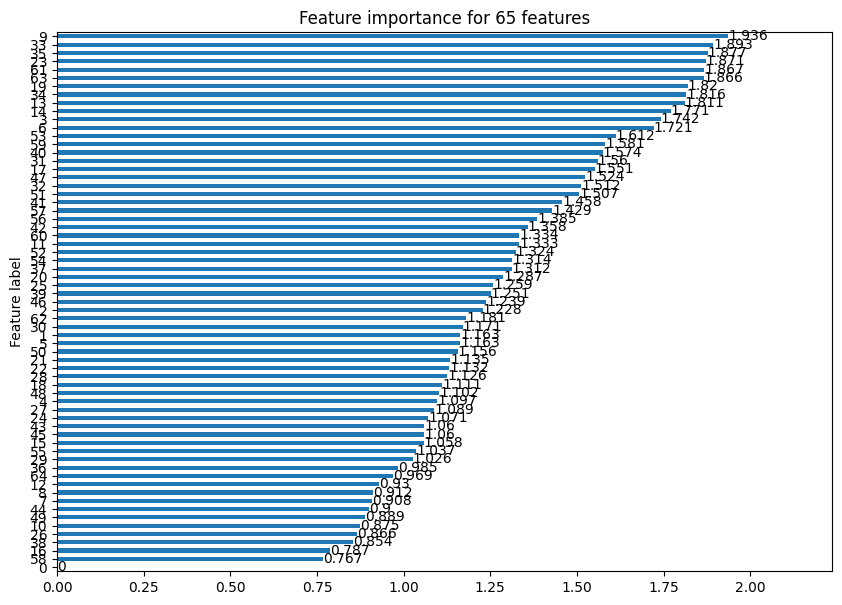

t2m_mean station_latitude mx2t6_mean u100_mean t_mean


In [37]:
explanation.visualize_feature_importance()
feature_names = [f for f in dataframes['test_f'][0].columns.tolist() if f not in ['time', 'number']] # dropped time and number: len - 65
print(feature_names[13], feature_names[3], feature_names[35], feature_names[23], feature_names[61])

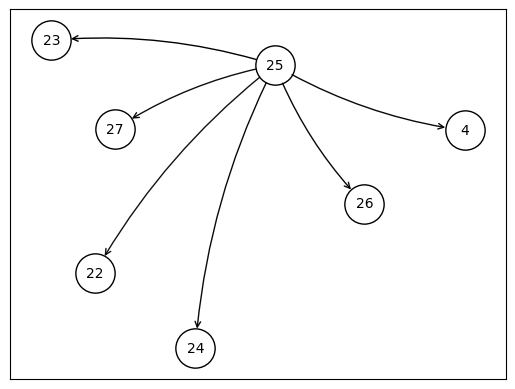

In [78]:
explanation.visualize_graph()
# is station actually only connected to stations 13 and 7?

In [32]:
node_feat_mask = explanation.node_mask.detach().cpu().numpy()
edge_mask = explanation.edge_mask.detach().cpu().numpy()

G = to_networkx(graph_to_explain, to_undirected=True)
nodes = set([node_idx])
neighbors = set(G.neighbors(node_idx))
print(neighbors)
print(nodes)

{13, 7}
{10}


In [33]:
nodes.update(neighbors)
# get neighbors of neighbors
for n in neighbors:
    nodes.update(G.neighbors(n))
print(nodes)
print(neighbors)

subgraph = G.subgraph(nodes)

{3, 5, 7, 10, 12, 13, 15}
{13, 7}


In [34]:
edges = list(subgraph.edges())
# print(edges)
edge_colors = []
edge_widths = []

edge_importance = {}
for i, (src, tgt) in enumerate(graph_to_explain.edge_index.t().tolist()):
    if edge_mask[i] != 0:
        edge_importance[(src, tgt)] = edge_mask[i]
        edge_importance[(tgt, src)] = edge_mask[i]

for edge in edges:
    # print(edge)
    importance = edge_importance.get(edge, 0)
    print(importance)
    if importance > 0:
        edge_colors.append(importance)
        edge_widths.append(1 + 4 * importance)
    else:
        edge_colors.append(0.1)
        edge_widths.append(0.5)

0
0
0.3410892
0.28107765
0
0


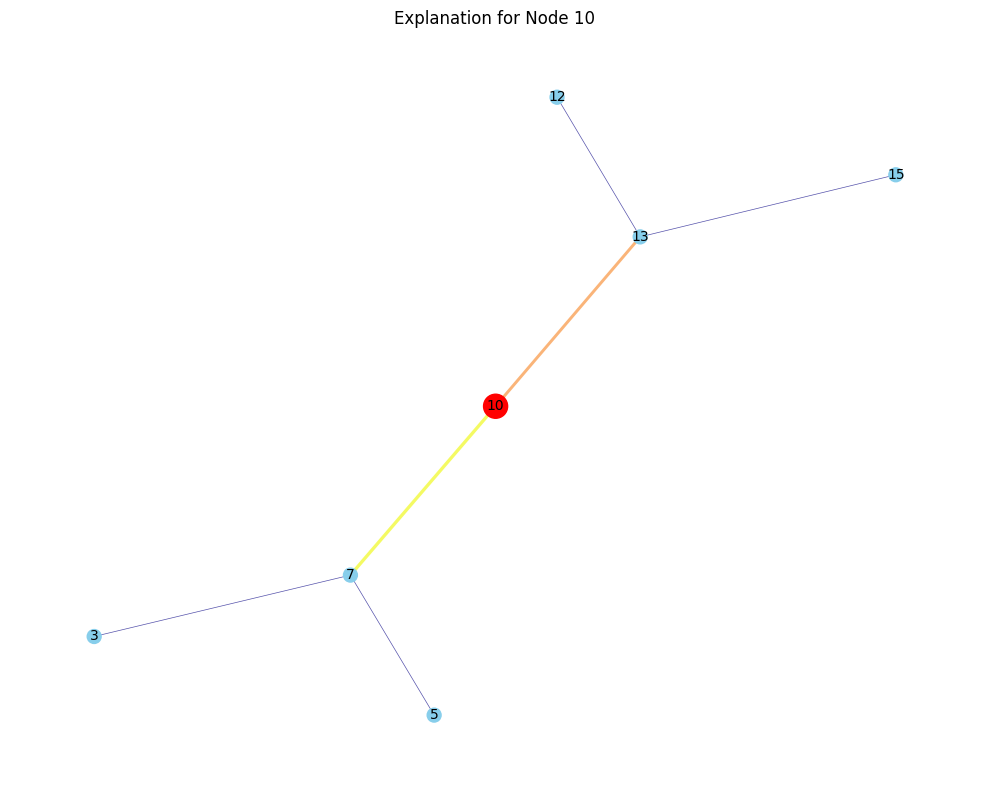

In [35]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_edges(
    subgraph, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    alpha=0.7
)

node_colors = ['red' if n == node_idx else 'skyblue' for n in subgraph.nodes()]
node_sizes = [300 if n == node_idx else 100 for n in subgraph.nodes()]

nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=list(subgraph.nodes()),
    node_color=node_colors,
    node_size=node_sizes
)

nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.axis('off')
plt.title(f'Explanation for Node {node_idx}')
plt.tight_layout()
plt.show()

# auf die Karte plotten
# welche Kanten überhaupt wichtig